In [12]:
import pandas as pd
import os
import numpy as np
import re

### ETL

In [70]:
df_raw_01 = pd.read_csv('ws_transcritor_database_v7.csv')
df_raw_02 = pd.read_csv('ws_transcritor_database_v8.csv')

df_raw = pd.concat([df_raw_01, df_raw_02])
df_raw.head()

,Phonetic,English,Portuguese,music_url
0,bikóz ai lâv̳,Because I love,Porque eu amo,https://www.cantaringles.com/because-i-love-so...
1,ól dei ai s̗ênk̳ óv̳ iú,All day I think of you,Todo dia eu penso em você,https://www.cantaringles.com/because-i-love-so...
2,iú fêl mai maind̳ fûl óv̳ dr̰ím̜s,You fill my mind full of dreams,Você enche minha mente de sonhos,https://www.cantaringles.com/because-i-love-so...
3,bikóz ai lâv̳,Because I love,Porque eu amo,https://www.cantaringles.com/because-i-love-so...
4,NaN,NaN,NaN,https://www.cantaringles.com/because-i-love-so...


In [72]:
df_raw.shape

(371944, 4)

In [10]:
df_raw.isnull().sum()

Phonetic      7481
English       7476
Portuguese    7493
music_url        0
dtype: int64

In [74]:
# Garantir que os dados são strings
df_v01 = df_raw.replace('', np.nan)
# Remover linhas que contêm NaN em qualquer coluna
df_v01.dropna(how='any', inplace=True)

df_v01.drop_duplicates(subset='English', keep='first', inplace=True)
df_v01.shape

(219504, 4)

In [76]:
df_v01['Phonetic'] = df_v01['Phonetic'].astype(str).str.lower()

In [113]:
substituicoes = {',': '', '(':'', ')':'', '.': '', '!': '', '?': '',
                 ' ´': '', '...': '', '-': ' ', '"': '', '…': '', '“':'',
                 '”': '',' ‘':'',' ‛':'', ':': ''}

df_v01 = df_v01.apply(lambda x: x.str.replace('|'.join(map(re.escape, substituicoes.keys())), 
                                      lambda match: substituicoes[match.group(0)], 
                                      regex=True))

df_v02 = df_v01.replace({r"\b'(\w+)": r"\1"}, regex=True)
# df_v01 = df_raw.replace(letras_replace)

In [24]:
df_v02.isnull().sum()

Phonetic      0
English       0
Portuguese    0
music_url     0
dtype: int64

In [28]:
# !pip install lingua-language-detector

In [115]:
from lingua import Language, LanguageDetectorBuilder
import pandas as pd

# Definir os idiomas que queremos detectar
languages = [Language.ENGLISH, Language.SPANISH]

# Criar o detector de idiomas otimizando para esses três idiomas
detector = LanguageDetectorBuilder.from_languages(*languages).build()

# Função para detectar idioma com `lingua`
def detect_lingua(text):
    lang = detector.detect_language_of(text)
    return lang.iso_code_639_1 if lang else "unknown"  # Retorna 'en', 'es', 'pt' ou 'unknown'

# Aplicar detecção ao DataFrame
df_v02['lang_lingua'] = df_v02['English'].apply(detect_lingua)

In [116]:
df_v03 = df_v02.copy()
df_v03['lang_lingua'] = df_v03['lang_lingua'].astype(str)

In [117]:
# Filtrar frases detectadas como espanhol ('es') ou português ('pt')
df_v03 = df_v03[~df_v03['lang_lingua'].isin(['IsoCode639_1.ES'])]
df_v03.shape

(218247, 5)

In [118]:
df_v03.lang_lingua.unique()

array(['IsoCode639_1.EN', 'unknown'], dtype=object)

In [119]:
df_v03 = df_v03[['English', 'Phonetic']].apply(lambda col: col.str.lower() if col.dtype == "object" else col)
df_v03.columns = ['english', 'phonetic']
df_v03 = df_v03.reset_index(drop = True)

In [37]:
len(df_v01.music_url.unique())

8472

### Quebra de frases

In [123]:
def quebrar_em_combinacoes(df):
    novos_dados = []

    for index, row in df.iterrows():
        source_words = row['english'].split()
        target_words = row['phonetic'].split()

        # Garantir que ambas as listas tenham o mesmo número de palavras
        if len(source_words) == len(target_words):
            for n in range(1, 9):  # pares (2) até quinas (5)
                for i in range(len(source_words) - n + 1):
                    novos_dados.append([
                        " ".join(source_words[i:i+n]), 
                        " ".join(target_words[i:i+n])
                    ])

    # Criar novo DataFrame com as combinações
    novo_df = pd.DataFrame(novos_dados, columns=['english', 'phonetic'])



    return novo_df

# Aplicar ao DataFrame original
database_combinations = quebrar_em_combinacoes(df_v03)


In [129]:
database_combinations = database_combinations.drop_duplicates()
database_combinations

(2291581, 2)

In [98]:
df_v01.head()

,Phonetic,English,Portuguese,music_url
0,bikóz ai lâv̳,Because I love,Porque eu amo,https://www.cantaringles.com/because-i-love-so...
1,ól dei ai s̗ênk̳ óv̳ iú,All day I think of you,Todo dia eu penso em você,https://www.cantaringles.com/because-i-love-so...
2,iú fêl mai maind̳ fûl óv̳ dr̰ím̜s,You fill my mind full of dreams,Você enche minha mente de sonhos,https://www.cantaringles.com/because-i-love-so...
5,ai si z̗ét̳ gâr̰l,I see that girl,Eu vejo aquela garota,https://www.cantaringles.com/because-i-love-so...
6,z̗ou xis far̰ âuêi,Though she’s far away,Embora ela esteja longe,https://www.cantaringles.com/because-i-love-so...


In [162]:
# def corrigir_apostrofos(texto):
#     if pd.isna(texto):
#         return texto
#     return (str(texto)
#             .replace('´', "'")   # Acento agudo → Apóstrofo
#             .replace('′', "'")   # Prime → Apóstrofo
#             .replace('’', "'")   # Aspas direita → Apóstrofo
#             .replace('‘', "'")   # Aspas esquerda → Apóstrofo
#            )

# # Aplicar a correção na coluna 'phonetic'
# final_database['english'] = final_database['english'].apply(corrigir_apostrofos)
# final_database['phonetic'] = final_database['phonetic'].apply(corrigir_apostrofos)

In [195]:
def limpar_apostrofos_inicio_fim(texto):
    if pd.isna(texto):
        return texto
    texto = str(texto)
    # 1. Remove apóstrofo no início da palavra
    texto = re.sub(r"(?<=\s)'", '', texto)  # Após espaço
    texto = re.sub(r"^'", '', texto)        # No começo da frase
    
    # 2. Remove apóstrofo no final da palavra
    texto = re.sub(r"'(?=\s|$)", '', texto)  # Antes de espaço ou fim da frase
    
    return texto

# Aplicar limpeza nas colunas
final_database['english'] = final_database['english'].apply(limpar_apostrofos_inicio_fim)

In [254]:
final_database.shape

(2291580, 2)

In [208]:
final_database.isnull().values.any()

False

In [228]:
# Função para identificar registros inválidos
def deve_remover(texto):
    if pd.isna(texto):
        return False
    texto = str(texto).strip().lower()
    palavras = texto.split()
    return (len(palavras) == 1 and palavras[0] == 'null') or (len(palavras) == 1 and palavras[0] == 'NaN')

# Aplicar a função na coluna desejada, por exemplo 'phonetic'
final_database = final_database[~final_database['english'].apply(deve_remover)]

In [232]:
# final_database.to_csv('words_and_frases_database_v8.csv', index=False)

In [145]:
# final_database.sample(n = 20, ignore_index = True).to_csv('amostra_words_and_frases_database_v8.csv', index=False)

In [244]:
# Função para categorizar frases
df = final_database.copy()

def categorizar_tamanho(frase):
    num_palavras = len(frase.split())
    if num_palavras == 1:
        return "Única palavra"
    elif 2 <= num_palavras <= 3:
        return "Curta (2–3 palavras)"
    elif 4 <= num_palavras <= 6:
        return "Média (4–6 palavras)"
    else:
        return "Longa (7+ palavras)"

# Aplicando no DataFrame
df['categoria_tamanho'] = final_database['english'].apply(categorizar_tamanho)

# Contagem por categoria
distribuicao = df['categoria_tamanho'].value_counts()
print(distribuicao)


categoria_tamanho
Média (4–6 palavras)    1269593
Curta (2–3 palavras)     689251
Longa (7+ palavras)      311221
Única palavra             21515
Name: count, dtype: int64


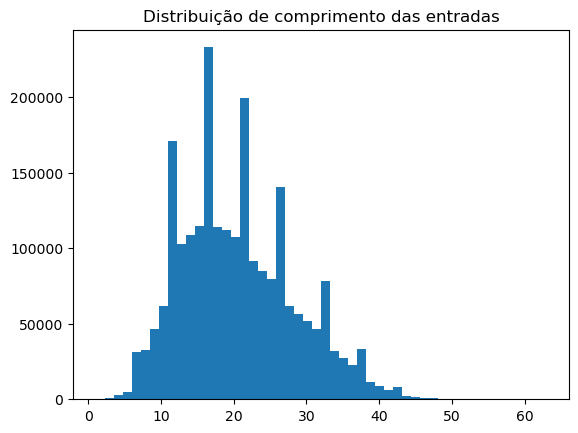

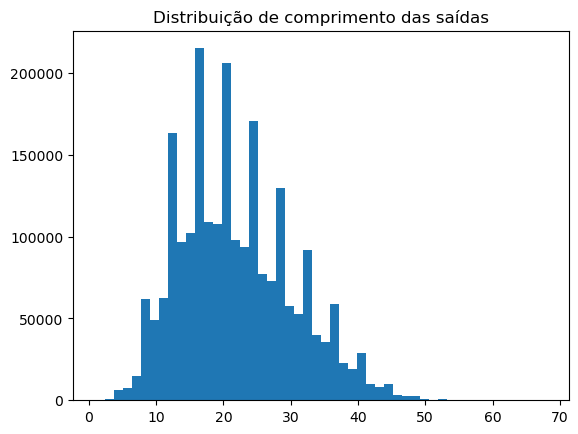

In [128]:
import matplotlib.pyplot as plt

final_database["english"] = final_database["english"].apply(len)
final_database["phonetic"] = final_database["phonetic"].apply(len)

plt.hist(final_database["english"], bins=50)
plt.title("Distribuição de comprimento das entradas")
plt.show()

plt.hist(final_database["phonetic"], bins=50)
plt.title("Distribuição de comprimento das saídas")
plt.show()

### Testando mapeamento de palavras